<div align="center"><h1>Проект по анализу данных</h1>
    <h4>Майнор "Интеллектуальный анализ данных", курс "Введение в анализ данных"</h4>
</div>
<hr>
Данный проект посвящен распознаванию рукописных цифр методами машинного обучения. В качестве источника данных используется <a href="http://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_digits.html">стандартный набор данных</a> из библиотеки scikit-learn. Данные разбиваются на подмножества с целью дальнейшего их использования при обучении и кросс-валидации для подбора параметров. Были использованы два алгоритма, примеры реализации которых для данной задачи были найдены в Интернет (подбор параметров осуществлялся мною):
<ul>
    <li>Логистическая регрессия;</li>
    <li>Метод опорных векторов.</li>
</ul>
<br>
Далее были применены алгоритмы, не рассматриваемые в данных примерах:
<ul>
    <li>K ближайших соседей;</li>
    <li>Случайный лес.</li>
</ul>
<br>
После подбора параметров и обучения на полной тренировочной выборке данные алгоритмы были сравнены по точности предсказания (accuracy) на тестовой выборке, после чего были сформированы выводы.

<h4>1. Импортируем все, что нам понадобится</h4>

In [236]:
from numpy import mean, arange

from sklearn.datasets import load_digits
from sklearn.cross_validation import train_test_split, KFold
from sklearn.svm import LinearSVC, SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.externals import joblib
import os

import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

<h4>2. Подготавливаем наши данные: загружаем, разбиваем на тренировочное, оценочное и проверочное подмножества</h4>

In [213]:
data = load_digits()
x_train_init, x_test, y_train_init, y_test = train_test_split(data.data, data.target, train_size=0.6)
kf = KFold(n=len(x_train_init), n_folds=4, shuffle=True, random_state=0)

Функция для дальнейшего рисования графиков

In [214]:
def plot_scores(name, deg, train, val, height=4, width=17):
    plt.figure(1, figsize=[width, height])
    plt.xticks(deg)
    plt.title(name)
    plt.plot(deg, train, color='red', lw=2)
    plt.plot(deg, val, color='blue', lw=2)
    plt.legend(["Train accuracy", "Val accuracy"])
    plt.grid(True)
    plt.show()

<h4>3. Обучение моделей</h4>
<h4>3.1. Логистическая регрессия</h4>
<h4>3.1.1. Подбор алгоритма</h4>

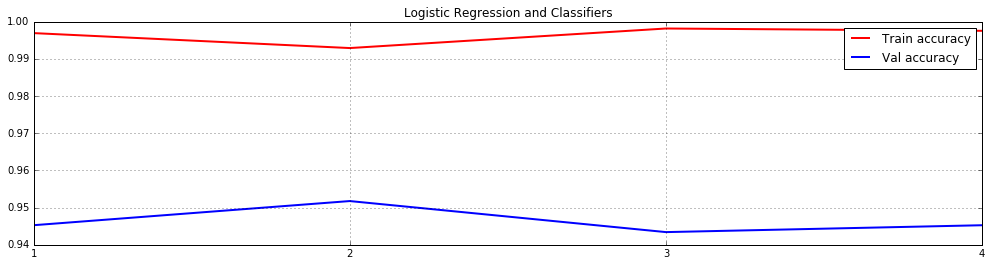

In [215]:
solvers = ['liblinear', 'sag', 'newton-cg', 'lbfgs']
scores_train = []
scores_val = []

for i in solvers:
    solv_train = []
    solv_val = []
    for train, val in kf:
        model = LogisticRegression(solver=i, random_state=0)
        model.fit(x_train_init[train], y_train_init[train])
        solv_train.append(model.score(x_train_init[train], y_train_init[train]))
        solv_val.append(model.score(x_train_init[val], y_train_init[val]))
    scores_train.append(mean(solv_train))
    scores_val.append(mean(solv_val))

# Для возможности построения графика алгоритмы пронумерованы, начиная с цифры 1
plot_scores("Logistic Regression and Classifiers", range(1, 5), scores_train, scores_val)

<p>Видно, что на оценочном подмножестве алгоритм "sag" работает лучше; возьмем его для дальнейших действий.</p>
<h4>3.1.2. Подбор количества итераций</h4>

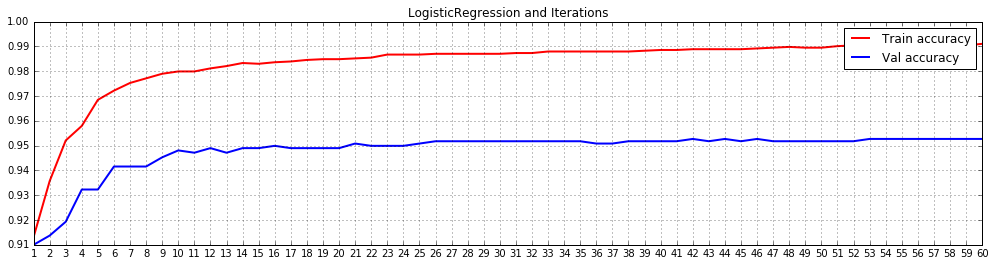

In [216]:
iterations = range(1, 61)
iter_train = []
iter_val = []

for i in iterations:
    iter_loop_train = []
    iter_loop_val = []
    for train, val in kf:
        model = LogisticRegression(solver='sag', max_iter=i, random_state=0)
        model.fit(x_train_init[train], y_train_init[train])
        iter_loop_train.append(model.score(x_train_init[train], y_train_init[train]))
        iter_loop_val.append(model.score(x_train_init[val], y_train_init[val]))
    iter_train.append(mean(iter_loop_train))
    iter_val.append(mean(iter_loop_val))
    
plot_scores("LogisticRegression and Iterations", iterations, iter_train, iter_val)

Возьмем количество итераций, равное 21, для дальнейших операций.
<h4>3.1.3. Обучение итоговой модели</h4>

In [226]:
logistic_model = LogisticRegression(solver="sag", max_iter=21, random_state=0)
logistic_model.fit(x_train_init, y_train_init)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=21, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=0, solver='sag', tol=0.0001,
          verbose=0, warm_start=False)

<h4>3.2. C-Support Vector Classification</h4>
<h4>3.2.1. Подбор параметра gamma</h4>

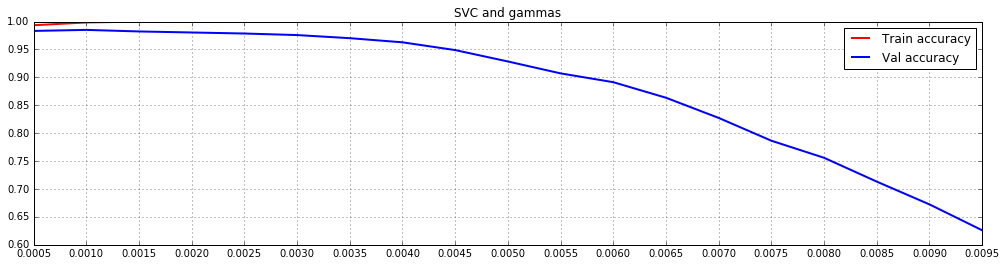

In [218]:
gammas = arange(0.0005, 0.01, 0.0005)
gamma_train = []
gamma_val = []

for i in gammas:
    gamma_loop_train = []
    gamma_loop_val = []
    for train, val in kf:
        model = SVC(gamma=i, random_state=0)
        model.fit(x_train_init[train], y_train_init[train])
        gamma_loop_train.append(model.score(x_train_init[train], y_train_init[train]))
        gamma_loop_val.append(model.score(x_train_init[val], y_train_init[val]))
    gamma_train.append(mean(gamma_loop_train))
    gamma_val.append(mean(gamma_loop_val))

plot_scores("SVC and gammas", gammas, gamma_train, gamma_val)

Возьмем значение 0.001, исходя из вышенаходящегося графика.
<h4>3.2.2. Обучение итоговой модели</h4>

In [219]:
svc_model = SVC(gamma=0.001, random_state=0)
svc_model.fit(x_train_init, y_train_init)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma=0.001, kernel='rbf',
  max_iter=-1, probability=False, random_state=0, shrinking=True,
  tol=0.001, verbose=False)

<h4>3.3. K Nearest Neighbours Classificator</h4>
Данный классификатор будет использоваться с параметром "weights", заданным как "distance".
<h4>3.3.1. Подбор количества соседей</h4>

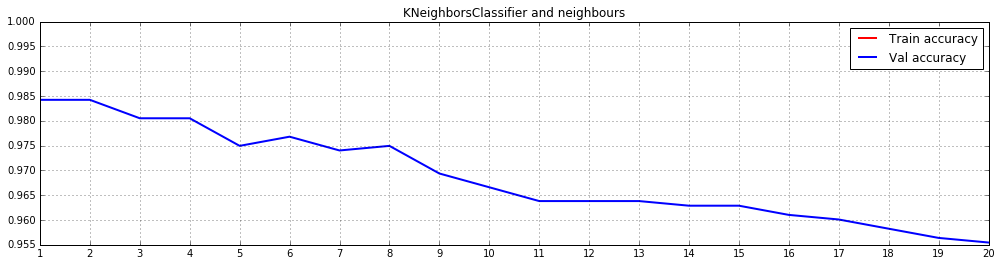

In [220]:
neighbours = range(1, 21)
n_train = []
n_val = []

for i in neighbours:
    n_loop_train = []
    n_loop_val = []
    for train, val in kf:
        model = KNeighborsClassifier(n_neighbors=i, weights='distance')
        model.fit(x_train_init[train], y_train_init[train])
        n_loop_train.append(model.score(x_train_init[train], y_train_init[train]))
        n_loop_val.append(model.score(x_train_init[val], y_train_init[val]))
    n_train.append(mean(n_loop_train))
    n_val.append(mean(n_loop_val))

plot_scores("KNeighborsClassifier and neighbours", neighbours, n_train, n_val)    

Возьмем количество соседей, равное 2, для дальнейших действий.
<h4>3.3.2. Обучение итоговой модели</h4>

In [231]:
kn_model = KNeighborsClassifier(n_neighbors=2, weights='distance')
kn_model.fit(x_train_init, y_train_init)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=2, p=2,
           weights='distance')

<h4>3.4. Random Forest Classifier</h4>
<h4>3.4.1. Подбор глубины</h4>

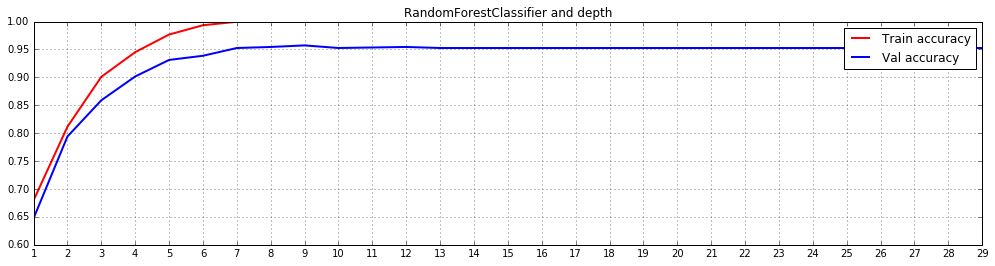

In [222]:
depth = range(1, 30)
depth_train = []
depth_val = []

for i in depth:
    trainDep = []
    valDep = []
    for train, val in kf:
        model = RandomForestClassifier(n_estimators=50, max_depth=i, criterion="entropy", bootstrap=True, 
                                    oob_score=False, random_state=0)
        model = model.fit(x_train_init[train], y_train_init[train])
        trainDep.append(model.score(x_train_init[train], y_train_init[train]))
        valDep.append(model.score(x_train_init[val], y_train_init[val]))
    depth_train.append(mean(trainDep))
    depth_val.append(mean(valDep))
    
plot_scores("RandomForestClassifier and depth", depth, depth_train, depth_val) 

Возьмем значение 11 для дальнейших операций.
<h4>3.4.2. Подбор количества деревьев</h4>

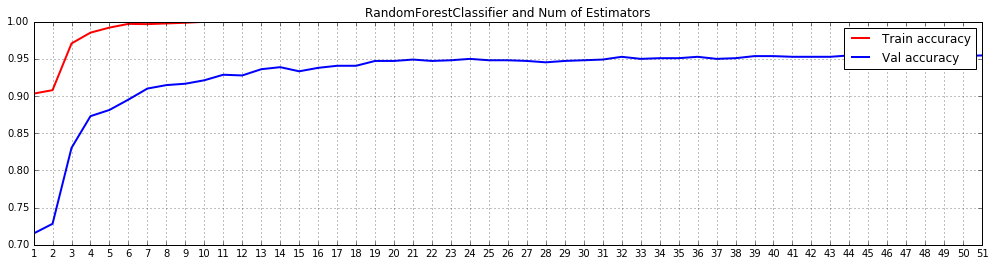

In [223]:
estimators = range(1, 52)
estim_train = []
estim_val = []

for i in estimators:
    trainDep = []
    valDep = []
    for train, val in kf:
        model = RandomForestClassifier(n_estimators=i, max_depth=11, criterion="entropy", bootstrap=True, 
                                    oob_score=False, random_state=0)
        model = model.fit(x_train_init[train], y_train_init[train])
        trainDep.append(model.score(x_train_init[train], y_train_init[train]))
        valDep.append(model.score(x_train_init[val], y_train_init[val]))
    estim_train.append(mean(trainDep))
    estim_val.append(mean(valDep))
    
plot_scores("RandomForestClassifier and Num of Estimators", estimators, estim_train, estim_val) 

Возьмем значение 50 для дальнейших действий.
<h4>3.4.3. Обучение итоговой модели</h4>

In [224]:
rfc_model = RandomForestClassifier(n_estimators=50, max_depth=11, criterion="entropy", bootstrap=True, 
                                    oob_score=False, random_state=0)
rfc_model.fit(x_train_init, y_train_init)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=11, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

<h4>4. Сравнение моделей на тестовой выборке</h4>

In [232]:
models = [(logistic_model, "Logistic Regression"), (svc_model, "C-Support Vector Classification"), 
          (kn_model, "K Nearest Neighbours"), (rfc_model, "Random Forest Classifier")]

for model in models:
    print(model[1])
    print("Score for the model: " + str(model[0].score(x_test, y_test)) + "\n")

Logistic Regression
Score for the model: 0.974965229485

C-Support Vector Classification
Score for the model: 0.993045897079

K Nearest Neighbours
Score for the model: 0.988873435327

Random Forest Classifier
Score for the model: 0.981919332406



На проверочном подмножестве оказалось, что C-Support Vector Classification показывает наибольшую точность, за ним следует K Nearest Neighbours, затем &mdash; Random Forest Classifier и Logistic Regression. Однако точность любого из алгоритмов не опускается ниже 97%, что говорит о достаточно высокой обобщающей способности обученных алгоритмов.

Таким образом, если есть необходимость распознавать рукописные цифры, то лучше всего использовать правильно обученный алгоритм опорных векторов. Естественно, что в данном проекте описаны не все возможные методы классификации, однако использованных здесь вполне хватает для достаточно точного предсказания.

<i>Мы можем сохранить наши модели для дальнейшего использования</i>

In [240]:
for model in models:
    if not os.path.exists("Project Classifiers/" + model[1]):
        os.makedirs("Project Classifiers/" + model[1])
    joblib.dump(model[0], "Project Classifiers/" + model[1] + '/' + model[1] + '.pkl') 